# Dog Identification App
## with Convolutional Neural Networks
 

---
Here, we develop an algorithm that could be used as part of a mobile or web app.  At the end, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of ur finished work.

---

![Sample Dog Output](images/sample_dog_output.png)

### The Content

We break the notebook into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Custom Algorithm
* [Step 6](#step6): Test our Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

We make sure that we've downloaded the required human and dog datasets:


* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this work's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


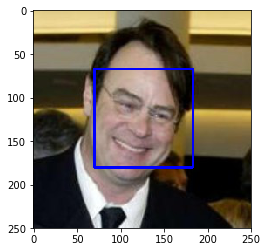

In [34]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
import cv2
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [5]:
face_detector('/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg')#rough

False

### Assess the Human Face Detector

Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_count, dog_count = 0, 0
for human_image in human_files_short:
    if face_detector(human_image):
        human_count += 1
for dog_image in dog_files_short:
    if face_detector(dog_image):
        dog_count += 1
print('{}% of humans images rightly classified\n{}% of dog images classified as humans' .format(human_count,dog_count))

98% of humans images rightly classified
17% of dog images classified as humans


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [21]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### Making Predictions with a Pre-trained Model

In the next code cell, we write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

You take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [7]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    img = Image.open(img_path) #open the image
    img = test_transforms(img)#transform the image
    img = img.unsqueeze(0) # Insert the new axis at index 0 i.e. in front of the other axes/dims
    VGG16.eval() # Prepare the model for evaluation
    output = VGG16(img) #make prediction
    output = output.data.numpy().argmax() #return the maximum probability
    
    return output# predicted class index

In [6]:
image_path = '/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg'
#VGG16_predict(image_path)

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

We use these ideas to write a `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [19]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    return VGG16_predict(img_path) in range(151,268+1) # true/false

In [12]:
dog_detector(image_path)

True

### Assess the Dog Detector

We use the code cell below to test the performance of our `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

In [14]:
### on the images in human_files_short and dog_files_short.
human_count, dog_count = 0, 0
for human_image in human_files_short:
    if dog_detector(human_image):
        human_count += 1
for dog_image in dog_files_short:
    if dog_detector(dog_image):
        dog_count += 1
print('{}% of humans images wrongly classified as dogs\n{}% of dog images were rightly classified'\
      .format(human_count,dog_count))

0% of humans images wrongly classified as dogs
100% of dog images were rightly classified


We suggest VGG-16 as a potential network to detect dog images in our algorithm, but we are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We will our CNN _from scratch_ and our goal is to attain a test accuracy of at least 10%.  In Step 4 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  This [documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) may be a useful resource.  For interest in augmenting the training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [8]:
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Specify appropriate transforms, and batch_sizes
data_dir = '/data/dog_images'

# transforms for the training(train), validation(valid) and testing(test) data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# store the transformed data
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [9]:
# get feature size
dataiter = iter(trainloader)
images, labels = dataiter.next()
n_input = 28*28*64

# get number of classes
class_names = train_data.classes
n_output = len(class_names)

loaders_scratch = {'train':trainloader, 'valid':validloader, 'test':testloader}

print('Input features: {}\nNo. of classes: {}'.format(n_input, n_output))

Input features: 50176
No. of classes: 133


### Model Architecture

Create a CNN to classify dog breed.

In [10]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # linear layer
        self.fc1 = nn.Linear(n_input, 500)
        self.fc2 = nn.Linear(500, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_output)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        ## Define forward behavior
        
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # flatten x
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        
        return x

In [18]:
# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=133, bias=True)
  (dropout): Dropout(p=0.2)
)


The steps we took to get to our final CNN architecture and the reasoning at each step:

- The first layer has input size of (224, 224, 3) and last layer should have the output size of 133 classes. The input size was as a result of the cropping. The ouput size was extracted from the dataset classes.
- 3 convolution layers was used. The input of the first is 3 because the image is colored (red, blue and green). The output size of each layer is becomes the input size of the next layer.
- The kernel size was taken as 3 and this led to padding of 1 inorder to carter for the extra unit created at the beginning and after the last unit of the pixel when the kernel travels. The stride is 1 to allow unit by unit movement.
- MaxPooling2D was taken as 2 to down-sample by reducing the x-y by factor of 2, while droput of 0.2 was chosen to reduce overfitting by ignoring some neurons in the layers.
- ReLU activation function was used in the hidden layers to create a nonlinear behaviour but was ignored in the output layer because the CrossEntropy error function takes care of that.
- Also, view was used to flatten the dimensions to a vector.

### Specify Loss Function and Optimizer

We use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [20]:
import torch.optim as optim

### select loss function
criterion_scratch = nn.CrossEntropyLoss()

### select optimizer
optimizer_scratch = torch.optim.SGD(model_scratch.parameters(), lr=0.03)

### Train and Validate the Model

Train and validate the model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [21]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, augmented_name):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            #train_loss += loss.item()*data.size(0)
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update average validation loss 
            #valid_loss += loss.item()*data.size(0)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

        # average losses
        train_loss = train_loss/len(loaders['train'].sampler)
        valid_loss = valid_loss/len(loaders['valid'].sampler)
   
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), augmented_name)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [12]:
# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt', 'model_augmented.pt')

Epoch: 1 	Training Loss: 0.000732 	Validation Loss: 0.005859
Validation loss decreased (inf --> 0.005859).  Saving model ...
Epoch: 2 	Training Loss: 0.000732 	Validation Loss: 0.005858
Validation loss decreased (0.005859 --> 0.005858).  Saving model ...
Epoch: 3 	Training Loss: 0.000732 	Validation Loss: 0.005857
Validation loss decreased (0.005858 --> 0.005857).  Saving model ...
Epoch: 4 	Training Loss: 0.000732 	Validation Loss: 0.005856
Validation loss decreased (0.005857 --> 0.005856).  Saving model ...
Epoch: 5 	Training Loss: 0.000732 	Validation Loss: 0.005854
Validation loss decreased (0.005856 --> 0.005854).  Saving model ...
Epoch: 6 	Training Loss: 0.000731 	Validation Loss: 0.005852
Validation loss decreased (0.005854 --> 0.005852).  Saving model ...
Epoch: 7 	Training Loss: 0.000731 	Validation Loss: 0.005849
Validation loss decreased (0.005852 --> 0.005849).  Saving model ...
Epoch: 8 	Training Loss: 0.000731 	Validation Loss: 0.005844
Validation loss decreased (0.00584

KeyboardInterrupt: 

We stopped the trainning along the way. Remember that we wrote the above training code so that at each decrease in loss the model output is saved. So although we stopped it on the way, the last saved model is in our folder.

In [10]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_augmented.pt'))

### Test the Model

We try out our model on the test dataset of dog images.  We use the code cell below to calculate and print the test loss and accuracy.  We ensure that our test accuracy is greater than 10%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [40]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.013148


Test Accuracy: 10% (87/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We now use transfer learning to create a CNN that can identify dog breed from images.  Our goal is to attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

We use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

We use, **the same data loaders from the previous step**, when we created a CNN from scratch.

In [11]:
import os
from torchvision import datasets

## Specify appropriate transforms, and batch_sizes

loaders_transfer = loaders_scratch.copy()

### Model Architecture

We use transfer learning to create a CNN to classify dog breed.  We use the code cell below, and save our initialized model as the variable `model_transfer`.

In [12]:
import torchvision.models as models
import torch.nn as nn

## Specify model architecture 
n_input = 4096
# define VGG16 model  
model_transfer = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.classifier[6] = nn.Linear(n_input, n_output, bias=True)
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 104140974.82it/s]


**The steps** we took to get to our final CNN architecture and the reasoning at each step.

- The same proceedure as 4 above was followed except few changes. Here transfer learning was used.
- vgg16 a trained model available in torchvision library was used. It has been trained to recognize dogs from images using lots of database and computing power and time.
- The last layer was changed to produce 10 classes instead of 2.
- The parameters were freezed to prevent being retrained during back propagation.

### Specify Loss Function and Optimizer

We use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [23]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(filter(lambda p: p.requires_grad,model_transfer.parameters()), lr=0.003)

### Train and Validate the Model

We train and validate our model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [10]:
# train the model
model_transfer = train(70, loaders_transfer, model_transfer,optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt', 'tranfer_model_augmented')


Epoch: 1 	Training Loss: 0.000664 	Validation Loss: 0.004193
Validation loss decreased (inf --> 0.004193).  Saving model ...
Epoch: 2 	Training Loss: 0.000510 	Validation Loss: 0.003028
Validation loss decreased (0.004193 --> 0.003028).  Saving model ...
Epoch: 3 	Training Loss: 0.000416 	Validation Loss: 0.002353
Validation loss decreased (0.003028 --> 0.002353).  Saving model ...
Epoch: 4 	Training Loss: 0.000358 	Validation Loss: 0.001915
Validation loss decreased (0.002353 --> 0.001915).  Saving model ...
Epoch: 5 	Training Loss: 0.000318 	Validation Loss: 0.001623
Validation loss decreased (0.001915 --> 0.001623).  Saving model ...
Epoch: 6 	Training Loss: 0.000291 	Validation Loss: 0.001415
Validation loss decreased (0.001623 --> 0.001415).  Saving model ...
Epoch: 7 	Training Loss: 0.000266 	Validation Loss: 0.001258
Validation loss decreased (0.001415 --> 0.001258).  Saving model ...
Epoch: 8 	Training Loss: 0.000254 	Validation Loss: 0.001146
Validation loss decreased (0.00125

In [13]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('tranfer_model_augmented'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [44]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.430504


Test Accuracy: 86% (723/836)


### Predict Dog Breed with the Model

We write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by our model.  

In [14]:
from PIL import Image
import torchvision.transforms as transforms
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in class_names]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path) #open the image
    img = test_transforms(img)#transform the image
    img = img.unsqueeze(0) # Insert the new axis at index 0 i.e. in front of the other axes/dims
    model_transfer.eval() # Prepare the model for evaluation
    output = model_transfer(img) #make prediction
    output = output.data.numpy().argmax() #return the maximum probability
    
    return class_names[output]


In [15]:
image_path = '/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg'

In [16]:
predict_breed_transfer(image_path)

'Bullmastiff'

---
<a id='step5'></a>
## Step 5: Prediction Algorithm

We write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We will use our CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below!

![Sample Human Output](images/sample_human_output.png)


In [43]:
def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    
    if dog_detector(img_path):
        print("Hello Dog!")
        show_image(img_path)
        print("Your breed is most likley ...\n{}".format(predict_breed_transfer(img_path)))
    
    elif face_detector(img_path):
        print("Hello, Human!")
        show_image(img_path)
        print("You look like a ...\n{}".format(predict_breed_transfer(img_path)))
    
    else:
        print("hmm, neither human no dog!!!")
        show_image(img_path)
        print("????????!")
    print('\n\n')

def show_image(img_path):
    image = Image.open(img_path)
    plt.imshow(image)
    plt.show()

---
<a id='step6'></a>
## Step 6: Test our Algorithm

In this section, we will take our new algorithm for a spin!  What kind of dog does the algorithm think that _we_ look like?  If we have a dog, does it predict our dog's breed accurately?  If we have a cat, does it mistakenly think that our cat is a dog?


**Is the output** better than we expected :) ?  Or worse :

__Answer:__ (Three possible points for improvement)

- Using better trained model like VGG-19 instead of VGG-16 will help improve accuracy.
- Training longer by increasing the number of epoch will help because the algorithm was getting better as the train and test error kept reducing.
- As alternative to the above point, adding more layers and introducing batchnormalization will help get better aaccuracy with smaller epoch because the model was not overfitting.
- Clearly, the face detactor was not doing very well, so using recent CNN face detectors which perform better. Imagine the photo of a boy with a baby the face detactor was not able to identify it.
- Class imbalance in dataset can be taken care of.


Hello, Human!


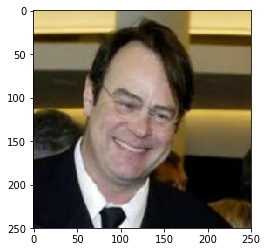

You look like a ...
Chihuahua


Hello, Human!


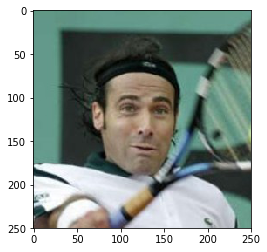

You look like a ...
Bearded collie


Hello, Human!


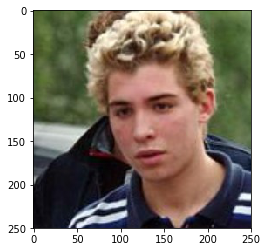

You look like a ...
Afghan hound


Hello Dog!


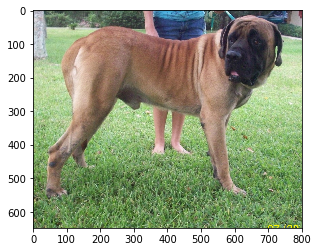

Your breed is most likley ...
Bullmastiff


Hello Dog!


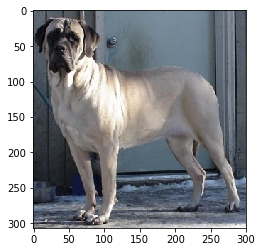

Your breed is most likley ...
Mastiff


Hello Dog!


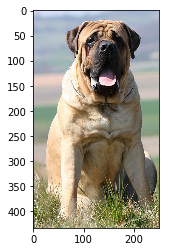

Your breed is most likley ...
Bullmastiff




In [36]:
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)
    print('\n')

hmm, neither human no dog!!!


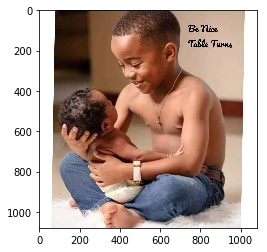

????????!



Hello, Human!


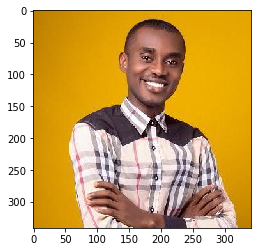

You look like a ...
Pharaoh hound



hmm, neither human no dog!!!


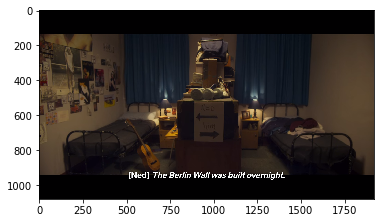

????????!



Hello, Human!


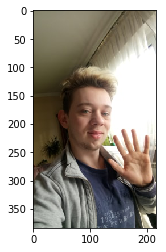

You look like a ...
Chinese crested



Hello, Human!


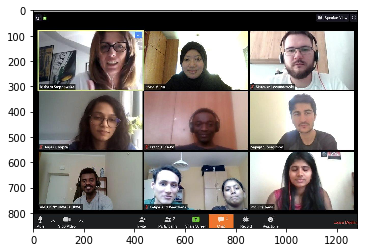

You look like a ...
Cocker spaniel



hmm, neither human no dog!!!


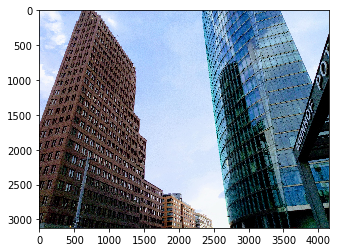

????????!



hmm, neither human no dog!!!


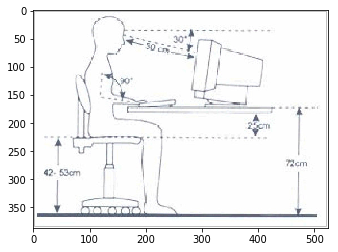

????????!



Hello, Human!


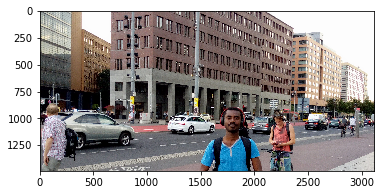

You look like a ...
Poodle





In [44]:
my_image = ['my_images/71543735_3127071060697368_7815347105706278912_o.jpg','my_images/Anthony.jpg',\
            'my_images/berling wall.png','my_images/Blazej.jpg','my_images/enterpreneurship first meeting.jpg',\
            'my_images/house.jpg','my_images/stanowisko komputerowe.jpg','my_images/tony.jpg']
for image in my_image:
    run_app(image)